In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import os

class COCOParser:
    def __init__(self, annotation_file):
        """
        Initialize the COCO parser with the annotation file
        
        Args:
            annotation_file (str): Path to the COCO annotation JSON file
        """
        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)
        
        # Create dictionary mappings for easier access
        self.images = {img['id']: img for img in self.coco_data['images']}
        self.categories = {cat['id']: cat for cat in self.coco_data['categories']}
        
        # Group annotations by image_id
        self.annotations_by_image = {}
        for ann in self.coco_data['annotations']:
            image_id = ann['image_id']
            if image_id not in self.annotations_by_image:
                self.annotations_by_image[image_id] = []
            self.annotations_by_image[image_id].append(ann)
    
    def get_image_info(self, image_id):
        """Get information about a specific image"""
        return self.images.get(image_id)
    
    def get_category_info(self, category_id):
        """Get information about a specific category"""
        return self.categories.get(category_id)
    
    def get_annotations(self, image_id):
        """Get all annotations for a specific image"""
        return self.annotations_by_image.get(image_id, [])
    
    def get_all_image_ids(self):
        """Get all image IDs in the dataset"""
        return list(self.images.keys())
    
    def get_all_category_ids(self):
        """Get all category IDs in the dataset"""
        return list(self.categories.keys())
    
    def visualize_image_annotations(self, image_id, image_dir, show_bbox=True, show_segmentation=True):
        """Visualize annotations for a specific image"""
        # Get image info and annotations
        image_info = self.get_image_info(image_id)
        if not image_info:
            print(f"Image ID {image_id} not found")
            return
        
        # Load the image
        image_path = os.path.join(image_dir, image_info['file_name'])
        if not os.path.exists(image_path):
            print(f"Image file {image_path} not found")
            return
        
        img = Image.open(image_path)
        fig, ax = plt.subplots(1, figsize=(12, 9))
        ax.imshow(img)
        
        # Get annotations for this image
        annotations = self.get_annotations(image_id)
        
        # Random colors for different categories
        colors = plt.cm.hsv(np.linspace(0, 1, len(self.categories) + 1)) #type: ignore
        
        for ann in annotations:
            category_id = ann['category_id']
            category_name = self.categories[category_id]['name']
            color = colors[category_id % len(colors)]
            
            # Draw bounding box
            if show_bbox and 'bbox' in ann:
                bbox = ann['bbox']
                # COCO format: [x, y, width, height]
                rect = patches.Rectangle(
                    (bbox[0], bbox[1]), bbox[2], bbox[3],
                    linewidth=2, edgecolor=color, facecolor='none'
                )
                ax.add_patch(rect)
                ax.text(bbox[0], bbox[1] - 5, category_name, 
                        color='white', fontsize=10, 
                        bbox=dict(facecolor=color, alpha=0.7))
            
            # Draw segmentation
            if show_segmentation and 'segmentation' in ann:
                for segmentation in ann['segmentation']:
                    poly = np.array(segmentation).reshape(-1, 2)
                    ax.plot(poly[:, 0], poly[:, 1], color=color, linewidth=2)
                    ax.fill(poly[:, 0], poly[:, 1], color=color, alpha=0.3)
        
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def print_dataset_stats(self):
        """Print statistics about the dataset"""
        print("Dataset Statistics:")
        print(f"Number of images: {len(self.images)}")
        print(f"Number of categories: {len(self.categories)}")
        print(f"Number of annotations: {len(self.coco_data['annotations'])}")
        
        # Count instances per category
        instances_per_category = {}
        for ann in self.coco_data['annotations']:
            cat_id = ann['category_id']
            if cat_id not in instances_per_category:
                instances_per_category[cat_id] = 0
            instances_per_category[cat_id] += 1
        
        print("\nInstances per category:")
        for cat_id, count in instances_per_category.items():
            cat_name = self.categories[cat_id]['name']
            print(f"{cat_name}: {count}")

Dataset Statistics:
Number of images: 509
Number of categories: 11
Number of annotations: 12675

Instances per category:
Outdoor: 651
Undefined: 1438
Kitchen: 358
Entry: 476
Living Room: 389
Bed Room: 636
Bath: 602
Storage: 374
Window: 3621
Door: 4080
Garage: 50

Visualizing annotations for image ID: 5870


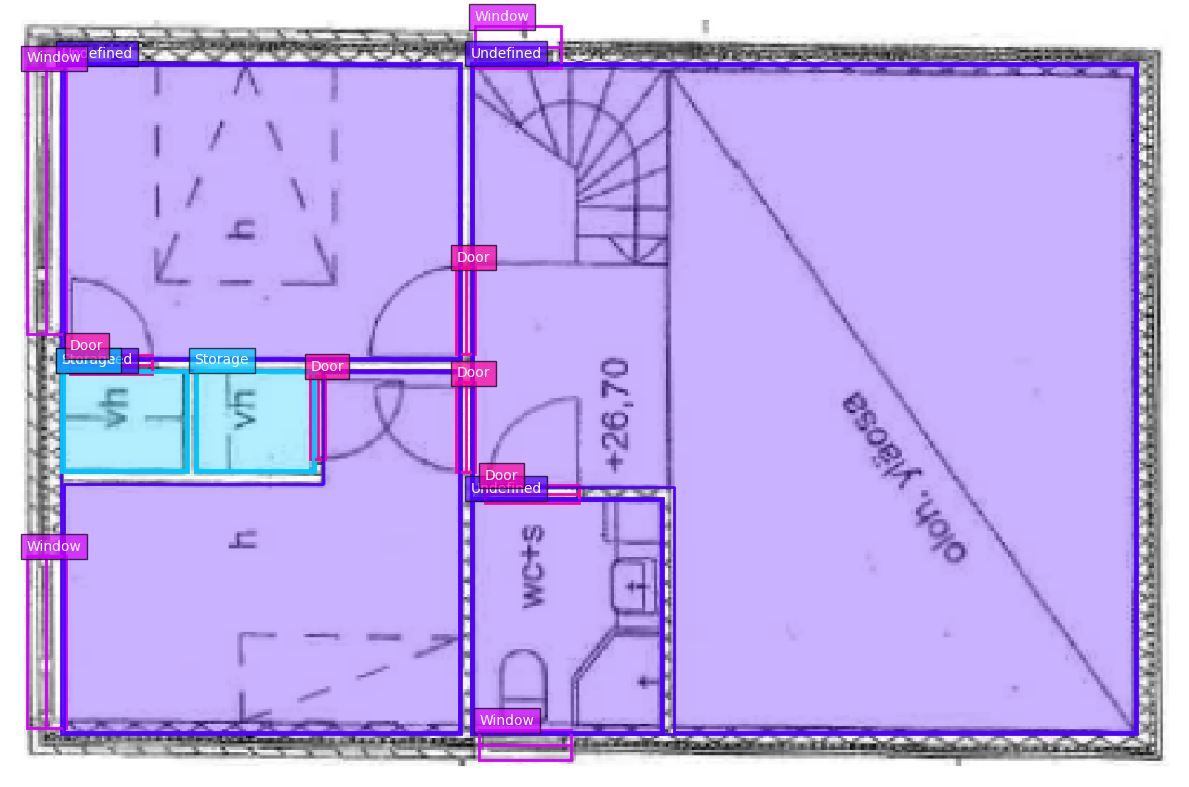

In [2]:
# Replace these with your actual paths
annotation_file = "test.json"
image_dir = "test"

parser = COCOParser(annotation_file)

# Print dataset statistics
parser.print_dataset_stats()

# Get all image IDs
image_ids = parser.get_all_image_ids()

# If there are images, visualize the first one

index = 100
if image_ids:
    print(f"\nVisualizing annotations for image ID: {image_ids[index]}")
    parser.visualize_image_annotations(image_ids[index], image_dir)

In [37]:
# Extract JSON for a single example corresponding to the image at index 'index'
index = 100
image_id = image_ids[index]
image_info = parser.get_image_info(image_id)
annotations = parser.get_annotations(image_id)

example_data = {
    "image_info": image_info,
    "annotations": annotations
}

# Save the extracted JSON to a file
with open("example.json", "w") as f:
    json.dump(example_data, f, indent=4)

print(f"Extracted JSON for image ID {image_id} written to example.json")

Extracted JSON for image ID 5870 written to example.json


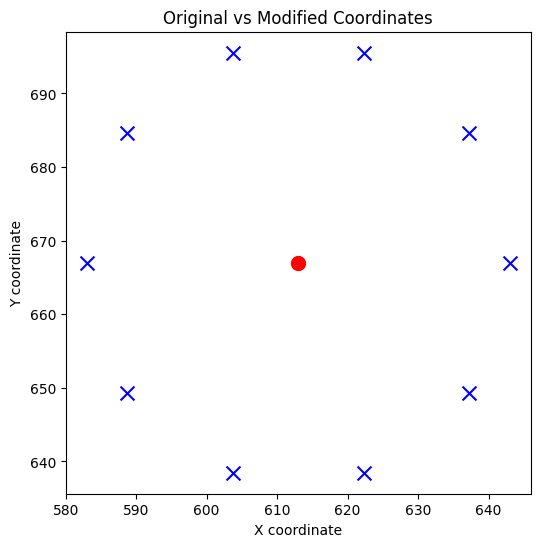

In [35]:
import math

# Read in the exported example JSON file
with open("example.json", "r") as f:
    data = json.load(f)

if input("Custom modification? (y/n): ").lower() == 'y':
    print("Annotations:")
    for i, ann in enumerate(data["annotations"]):
        print(f"{i}: Annotation ID {ann.get('id', 'N/A')}")
    # Let the user choose which annotation and which segmentation polygon to modify
    ann_index = int(input("Enter the index of the annotation to modify: "))
    print(f"\nSelected annotation ID: {data['annotations'][ann_index].get('id', 'N/A')}")
    print(f"Number of segmentation polygons: {len(data['annotations'][ann_index].get('segmentation', []))}")
    seg_index = int(input("Enter the index of the segmentation polygon to modify in this annotation: "))
    print(f"\nSelected segmentation polygon index: {seg_index}")
    print(f"Number of points in the segmentation polygon: {len(data['annotations'][ann_index]['segmentation'][seg_index]) // 2}")
    point_index = int(input("Enter the index of the point (in the polygon) to modify (point index, not list index): "))
    print(f"\nSelected point index: {point_index}")
    print(f"Current coordinates: {data['annotations'][ann_index]['segmentation'][seg_index][2 * point_index]}, {data['annotations'][ann_index]['segmentation'][seg_index][2 * point_index + 1]}")
    x_new = float(input("Enter the new x coordinate value: "))
    y_new = float(input("Enter the new y coordinate value: "))
else:
    ann_index = 0  # Default to the first annotation
    seg_index = 0  # Default to the first segmentation polygon
    point_index = 1

file = open("examples.txt", "w")

new_points = []
segmentation = data["annotations"][ann_index]["segmentation"]
seg_polygon = segmentation[seg_index]
orig_x = seg_polygon[2 * point_index]
orig_y = seg_polygon[2 * point_index + 1]

for i in range(10):
    # Assume that each segmentation polygon is a flat list of coordinates: [x0, y0, x1, y1, ...]
    # Changing a point means updating two consecutive values:
    if seg_index >= len(segmentation):
        print("Invalid segmentation polygon index.")
    else:
        if 2 * point_index + 1 >= len(seg_polygon):
            print("Invalid point index in the segmentation polygon.")
        else:
            angle = 2*math.pi * i / 10  # Angle for the new point
            radius = 30  # Random radius from a normal distribution
            
            x_new = orig_x + radius * math.cos(angle)
            y_new = orig_y + radius * math.sin(angle)
            seg_polygon[2 * point_index] = x_new
            seg_polygon[2 * point_index + 1] = y_new
            new_points.append((x_new, y_new))

            # Reassign the updated segmentation polygon back (not strictly necessary if modified in place)
            data["annotations"][ann_index]["segmentation"][seg_index] = seg_polygon
            # Write the modified JSON back to a new file
            json.dump(data, file, indent=4)
            file.write("\n")
file.close()

# Plot the original and modified point
fig, ax = plt.subplots(figsize=(6, 6))

# Plot modified points (blue cross)
for x_new, y_new in new_points:
    ax.scatter(x_new, y_new, color='blue', marker='x', s=100, label='Modified Point')

# Plot original point (red circle)
ax.scatter(orig_x, orig_y, color='red', marker='o', s=100, label='Original Point')

ax.set_xlabel("X coordinate")
ax.set_ylabel("Y coordinate")
ax.set_title("Original vs Modified Coordinates")

plt.show()

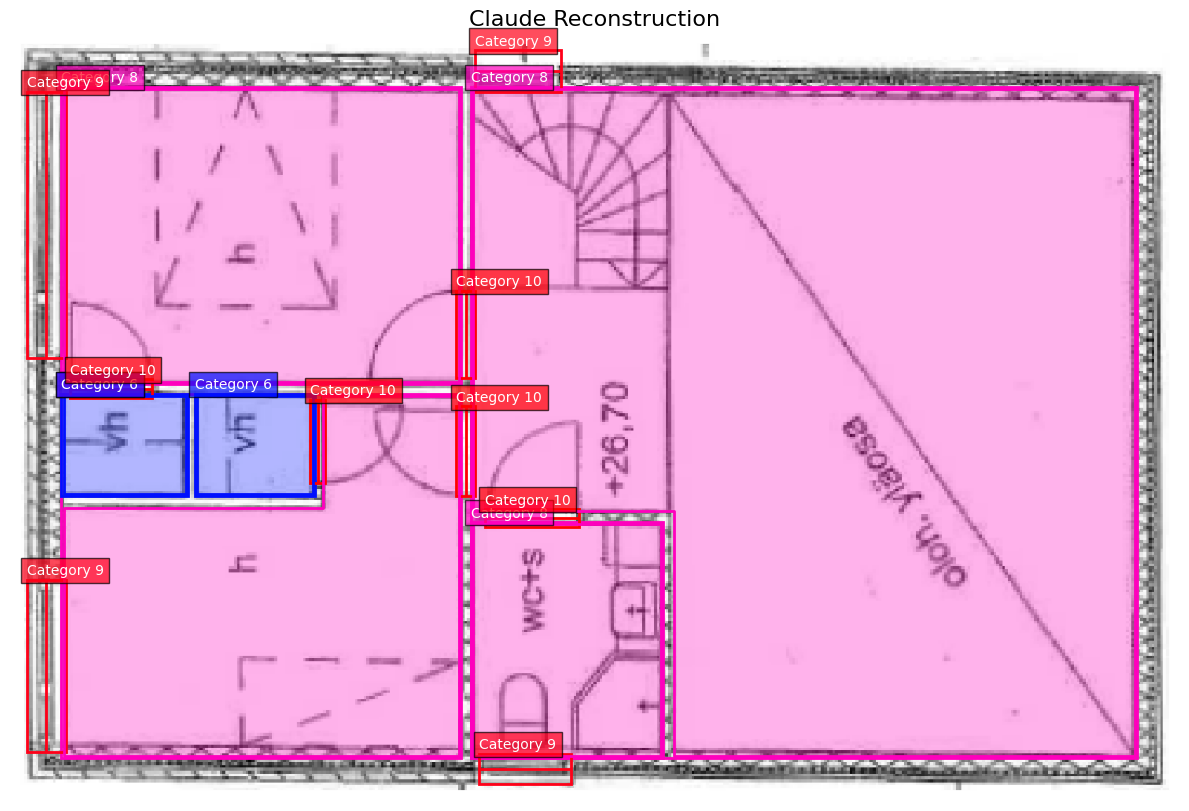

In [42]:
# Load the exported example JSON file that contains image_info and annotations
with open("example.json", "r") as f:
    example_data = json.load(f)

image_info = example_data["image_info"]
annotations = example_data["annotations"]

# Construct the image file path using the existing image_dir variable
image_path = os.path.join(image_dir, image_info["file_name"])
if not os.path.exists(image_path):
    print(f"Image file {image_path} not found.")
else:
    img = Image.open(image_path)
    
    # Plot the image and overlay the annotations
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img)
    
    # Use a color map for consistent colors
    colors = plt.get_cmap("hsv")(np.linspace(0, 1, 10))  # adjust size as needed
    
    for ann in annotations:
        cat_id = ann.get("category_id", 0)
        category_name = f"Category {cat_id}"
        color = colors[cat_id % len(colors)]
        
        # Draw bounding box if available
        if 'bbox' in ann:
            bbox = ann['bbox']  # COCO format: [x, y, width, height]
            rect = patches.Rectangle(
                (bbox[0], bbox[1]), bbox[2], bbox[3],
                linewidth=2, edgecolor=color, facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(bbox[0], bbox[1]-5, category_name, 
                    color='white', fontsize=10, 
                    bbox=dict(facecolor=color, alpha=0.7))
        
        # Draw segmentation if available
        if 'segmentation' in ann:
            for seg in ann['segmentation']:
                poly = np.array(seg).reshape(-1, 2)
                ax.plot(poly[:, 0], poly[:, 1], color=color, linewidth=2)
                ax.fill(poly[:, 0], poly[:, 1], color=color, alpha=0.3)
    ax.set_title("Claude Reconstruction", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    

In [98]:
print(f"\nAnnotations for image ID {image_ids[index]}:")

parser.get_annotations(image_ids[index])


Annotations for image ID 5870:


[{'segmentation': [[1039.0,
    667.0,
    613.0,
    667.0,
    613.0,
    441.0,
    427.0,
    441.0,
    427.0,
    51.0,
    1039.0,
    51.0,
    1039.0,
    667.0]],
  'area': 334956.0,
  'iscrowd': 0,
  'image_id': 5870,
  'bbox': [425.0, 49.0, 616.0, 620.0],
  'category_id': 8,
  'id': 2791},
 {'segmentation': [[414.0,
    667.0,
    49.0,
    667.0,
    49.0,
    438.0,
    289.0,
    438.0,
    289.0,
    334.0,
    414.0,
    334.0,
    414.0,
    667.0]],
  'area': 96585.0,
  'iscrowd': 0,
  'image_id': 5870,
  'bbox': [47.0, 332.0, 369.0, 337.0],
  'category_id': 8,
  'id': 2792},
 {'segmentation': [[414.0,
    321.0,
    49.0,
    321.0,
    49.0,
    51.0,
    414.0,
    51.0,
    414.0,
    321.0]],
  'area': 98550.0,
  'iscrowd': 0,
  'image_id': 5870,
  'bbox': [47.0, 49.0, 369.0, 274.0],
  'category_id': 8,
  'id': 2793},
 {'segmentation': [[601.0,
    667.0,
    427.0,
    667.0,
    427.0,
    453.0,
    601.0,
    453.0,
    601.0,
    667.0]],
  'area': 37236.0,

In [99]:
index = 0


file = open("ICL.txt", "w")
predictions_path = "eval_cubi/jsons/"

for i in range(1, 10):
    path = predictions_path + f"0{image_ids[i]}_pred.json"
    with open(path, 'r') as f:
        pred = json.load(f)

    file.write("Prediction:\n")
    file.write(str(pred))
    file.write("\n")
    file.write("Ground Truth:\n")
    file.write(str(parser.get_annotations(image_ids[i])))
    file.write("\n")

iclindex = 500

path = predictions_path + f"0{image_ids[iclindex]}_pred.json"
with open(path, 'r') as f:
    pred = json.load(f)

file.write("\nPrediction:\n")
file.write(str(pred))
file.close()

In [4]:
# Load annotations from output.json
def make_complete(path):
    with open("llmpreds/"+path, 'r') as f:
        annotations = json.load(f)

    left_shift = 180  # amount to move annotations left
    scale = 4.2

    # Scale up annotations: multiply bbox and segmentation coordinates by 4 (area by 16)
    # Then shift annotations left by subtracting left_shift from x coordinates
    for ann in annotations:
        if 'bbox' in ann:
            # COCO format: [x, y, width, height]
            scaled_bbox = [x * scale for x in ann['bbox']]
            scaled_bbox[0] -= left_shift  # shift x coordinate left
            ann['bbox'] = scaled_bbox
        if 'segmentation' in ann:
            new_segmentation = []
            for seg in ann['segmentation']:
                # Scale coordinates by 4
                scaled_seg = [x * scale for x in seg]
                # Shift every x coordinate (even indices) to left
                shifted_seg = [coord - left_shift if i % 2 == 0 else coord for i, coord in enumerate(scaled_seg)]
                new_segmentation.append(shifted_seg)
            ann['segmentation'] = new_segmentation
        if 'area' in ann:
            ann['area'] = ann['area'] * 16

    # Create a minimal COCO format structure
    coco_data = {
        'images': [],
        'categories': [],
        'annotations': annotations
    }

    # Extract unique image_ids and add to images
    image_ids2 = set([ann['image_id'] for ann in annotations])
    for img_id in image_ids2:
        coco_data['images'].append({
            'id': img_id,
            'file_name': f'0{img_id}.png',  # Dummy filename
            'width': 512,  # Default width
            'height': 512  # Default height
        })

    # Extract unique category_ids and add to categories
    category_ids = set([ann['category_id'] for ann in annotations])
    for cat_id in category_ids:
        coco_data['categories'].append({
            'id': cat_id,
            'name': f'Category {cat_id}',  # Dummy name
            'supercategory': 'object'
        })

    # Save the complete COCO format data
    with open('llmpreds/complete_'+path, 'w') as f:
        json.dump(coco_data, f)

In [101]:

def plotseq(id, parser2):
    parser.visualize_image_annotations(id, image_dir)
    parser2.visualize_image_annotations(id, image_dir)

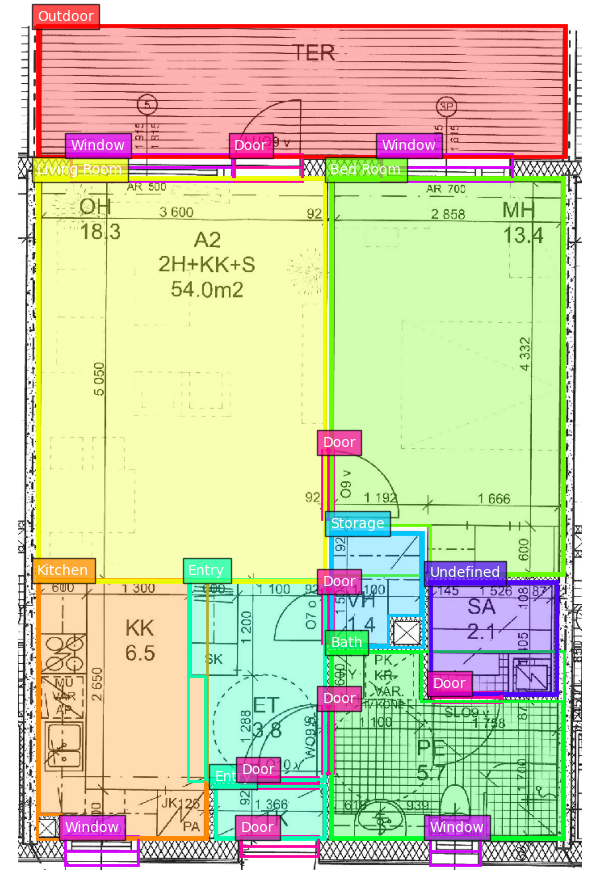

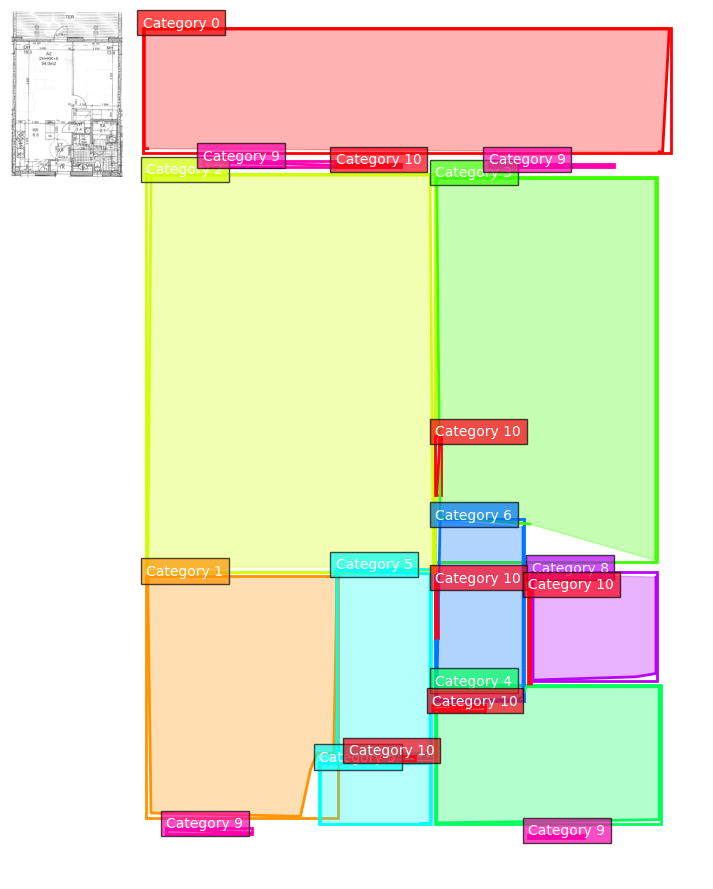

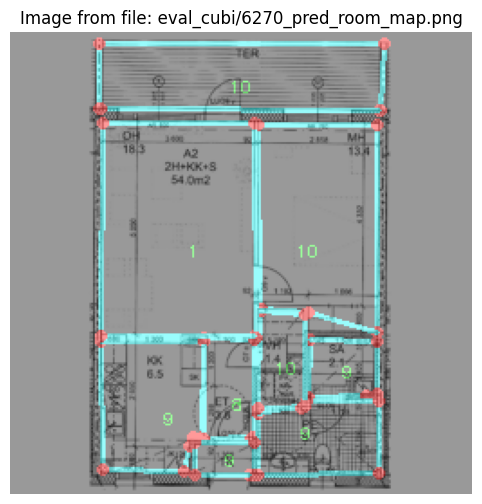

In [111]:
make_complete("6270.json")

parser2 = COCOParser('llmpreds/complete_6270.json')
# parser2 = COCOParser('eval_cubi/jsons/06270_pred.json')

id = parser2.get_all_image_ids()[0]

a = plotseq(id, parser2)

img_path = f'eval_cubi/{id}_pred_room_map.png'
if os.path.exists(img_path):
    img = Image.open(img_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Image from file: {img_path}')
    plt.show()